# Clipping raster to a shapefile
When there is a satellite image, rarely a scientist or data analyst is interested in the entire satellite image. Clipping satellite image is important to better visualize the area of interest. Shapefiles (vector data) can be used as a boundary defining the area of interest and mask (discard) the unnecessary data. The following satellite image contains landsat image which is clipped to a Grand Lake O' The Cherokees shapefile. 

**DJL: Do you really need all of these imports?**

**Abhiram: I removed the unnecessary imports**

In [1]:
#Import the required libraries to open and work with both raster and shapefiles
from osgeo import gdal, ogr, osr
import shapefile
from matplotlib import pyplot as plt, patches
from PIL import Image, ImageDraw
import os 
import urllib
import numpy as np
from zipfile import ZipFile

# Steps to clip raster to a shapefile
1. Load the image into an array
2. Read shapefile using pyshp
3. Convert shapefile into a georeferenced image 
4. Grab the required part of the georeferenced image based on the bounding box of the shapefile
5. Filter the selected image using mask created by PIL library
6. Save the output clipped raster as 'Grandlake.tif'

**DJL Comments: 
The vector file you sent shows up at a lat/lon of 13.5, -96.8. I don't know where you got this file, but it is not projected correctly. Try this one:
https://www.owrb.ok.gov/studies/surface/bathymetry.php   
Add a download for the vector file also, if it isn't present. It will come zipped, so you'll need to include code to unzip it.  
Why did you use requests instead of urllib? I've suggested changes...**


**Abhiram: I gave the web address to download the zipfile of the vector layer and unzip all the files to the working directory**

In [2]:
# local file path to the raster image
raster = "LC08_L1TP_026035_20160917_20170222_01_T1_B5.TIF"

# internet location for raster image
url = 'http://dl.dropboxusercontent.com/s/flsn5dfgzcwl6hc/LC08_L1TP_026035_20160917_20170222_01_T1_B5.TIF?dl=0'

# internet location for shapefile
weblink = 'https://dl.dropboxusercontent.com/s/ble1h5nqlu5rs09/Grand_lake.zip?dl=0'



# vector shapefile used in the clipping process
shp = "Grand_Lake_4326"

# Give the name of the output clipped raster file
output = "Grandlake"

# Use urllib library to download the raster file from web if it isn't present
if not os.path.isfile(raster):
    print('Downloading the raster file from {}'.format(url))
    urllib.request.urlretrieve(url, raster)
    print('done!')
else: 
    print('Raster file {} exists'.format(raster))
    
# Use urllib library to download the vector file fom web if it isn't present 

if not os.path.isfile(shp):
    print('Downloading the  shapefile from {}'.format(weblink))
    urllib.request.urlretrieve(weblink, shp)
    print('done!')
else: 
    print('Shapefile {} exists'.format(shp))

print(os.getcwd())
zf = ZipFile(r"{}\{}".format(os.getcwd(),"Grand_Lake_4326"), 'r')
zf.extractall("{}".format(os.getcwd()))
zf.close()

Raster file LC08_L1TP_026035_20160917_20170222_01_T1_B5.TIF exists
Shapefile Grand_Lake_4326 exists
C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\github\Clipping_raster


In [3]:
# First read the raster as an array using gdal and plot the array using matplotlib
srcImage = gdal.Open(raster)

#get the number of bands information from the rasterfile
band = srcImage.GetRasterBand(1)

#Reading the raster data as an array
srcArray = srcImage.ReadAsArray()
nrows, ncols = srcArray.shape

print(nrows,ncols)

7921 7791


(228885.0, 30.0, 0.0, 4108515.0, 0.0, -30.0)
462615.0 3870885.0


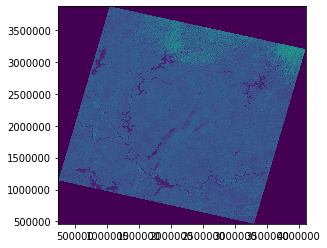

In [4]:
# To get the world info geotransform is used in gdal
geoTrans = srcImage.GetGeoTransform()
print(geoTrans)

x0 = geoTrans[0]
y0 = geoTrans[3]
w = geoTrans[1]
h = geoTrans[5]

#find the bottom right corner
xmax = x0+ncols*w
ymax = y0+nrows*h
print(xmax,ymax)

#Give the extent
extent = x0, y0, xmax, ymax


#Plot the image array
%matplotlib inline
plt.imshow(srcArray, extent = extent)

In [5]:
%matplotlib inline
# Use pyshp to read the shapefile
sf = shapefile.Reader("{}.shp".format(shp))
print(len(sf.shapes()))
print(sf.fields)

for shape in list(sf.iterShapes()):
    npoints = len(shape.points)
    print(npoints)
    nparts = len(shape.parts)
    print(nparts)

1
[('DeletionFlag', 'C', 1, 0), ['ELEVATION', 'N', 19, 11], ['ACRES', 'N', 19, 11], ['DEPTH', 'N', 19, 11], ['Shape_Leng', 'N', 19, 11], ['Shape_Area', 'N', 19, 11], ['SHLINE_MI', 'N', 11, 2]]
58233
55


**Abhiram: I shortened the code to plot all the parts in the vector file**

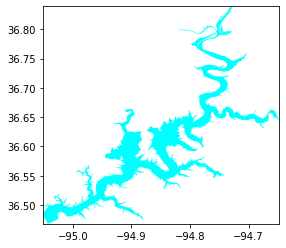

In [6]:
# Plotting the shapefile to check how the shapfile of the grandlake looks like
%matplotlib inline
#Plotting a single shape over the map
shape = sf.shape(0)

#Giving the extent of the shapefile 
minx, miny, maxx, maxy = shape.bbox

#Plotting shapefile with different parts
fig = plt.figure()
ax = fig.add_subplot(111, aspect = 'equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        x = [i[0] for i in shape.shape.points[i_start:i_end]]
        y = [i[1] for i in shape.shape.points[i_start:i_end]]
        
        points = [(x[i],y[i]) for i in range(0,len(x))]
        ax.add_patch(patches.Polygon(points, fc = 'aqua'))

(409870.95058973884, 3984410.788075776, 0.0)


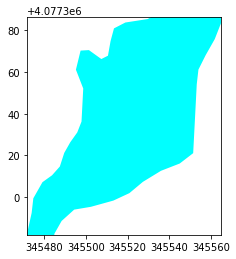

In [8]:
# get the source reference
driver = ogr.GetDriverByName('ESRI Shapefile')
dataset = driver.Open(shp + '.shp')
layer = dataset.GetLayer()
inSpatialRef = layer.GetSpatialRef()
dataset = None

# get the destination reference
outSpatialRef = osr.SpatialReference()
dataset = gdal.Open(raster)
prj = dataset.GetProjection()
outSpatialRef = osr.SpatialReference(wkt=prj)
dataset = None

# create the transform
transform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

lon = []
lat = []

print(transform.TransformPoint(-94,36))
for i,j in points:
    x,y,z = transform.TransformPoint(i,j)
    lon.append(x)
    lat.append(y)
    
    
new_points = [(lon[i],lat[i]) for i in range(0,len(lon))]

#print(new_points)

xmi, ymi = min(new_points)

xma, yma = max(new_points)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, aspect = 'equal')
ax.set_xlim(xmi,xma)
ax.set_ylim(ymi,yma)
ax.add_patch(patches.Polygon(new_points, fc = 'aqua'))

# Pixel location of geospatitial coordinate
The following function calculates the pixel location of the geospatital coordinate based on the GetGeoTransform function. The GeoTransform function consists of coordinates in the upper left corner of the image, pixel spacing and an additional rotation. By knowing these values, location of each pixel can be easily identified such that 

1. "228885" represents the upper left east coordinate (Horizontal)
2. "30" is the E-W pixel spacing
3. There is no rotation of the image (0 represents the image is pointing "North")
4. "4108515" represens the north coordinate of the image (Vertical)
5. There is no rotation of the image (0 degrees)
6. "-30" The N-S pixel spacing, negative as we will be counting from upper left corner

In [29]:
def world_to_pixel(geo_matrix, x, y):
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = int((x - ul_x) / x_dist)
    line = -int((ul_y - y) / y_dist)
    return pixel, line

In [36]:
ulX, ulY = world_to_pixel(geoTrans, xmin, ymax)
lrX, lrY = world_to_pixel(geoTrans, xmax, ymin)
print(ulX, lrX)
print(ulY, lrY)

3886 3889
1037 1041


3
4


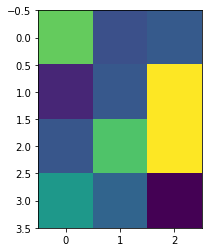

In [38]:
pxWidth = int(lrX - ulX)
pxHeight = int(lrY - ulY)
print(pxWidth)
print(pxHeight)
clip = srcArray[ulY:lrY, ulX:lrX]
plt.imshow(clip)

In [ ]:
#Create a new geomatrix for the clipped image 
geoTrans = list(geoTrans)
geoTrans[0] = minX
geoTrans[3] = maxY

In [ ]:
#Creating an 8 bit, black and white mask to mask the image and map points to pixels to draw the boundary of the grand lake
pixels = []
for pixel in sf.shape(0).points:
    pixels.append(world2Pixel(geoTrans, pixel[0], pixel[1]))
rasterPoly = Image.new("L", (pxWidth, pxHeight), 1)
plt.imshow(rasterPoly) 

In [ ]:
# Create a blank image in PIL to draw the grandlake polygon
rasterize = ImageDraw.Draw(rasterPoly)
rasterize.polygon(pixels, 0)

In [ ]:
# Now the black and white image can be converted to an array using the following function
def imageToArray(rasterPoly):
    """
    Converts a Python Imaging Library array to a gdal_array image.
    """
    mask = gdal_array.numpy.frombuffer(rasterPoly.tobytes(), 'b')
    print(mask.shape)
    mask.shape = rasterPoly.im.size[1], rasterPoly.im.size[0]
    print(mask.shape)
    return mask
mask = imageToArray(rasterPoly)
plt.imshow(mask)

In [ ]:

# Clip the image using the mask
clip = gdal_array.numpy.choose(mask, (clip, 0)).astype(
                                gdal_array.numpy.uint8)
plt.imshow(clip)